### Notebook Goal

To create a machine learning model that recognizes hate speech messages to automatically detect and remove these messages from YouTube comments. This will reduce the workload of moderators and help create a safer environment for users.

### Importing Libraries and Dataset

In [74]:
!pip install wordcloud==1.9.2 -q
!pip install emoji==2.8.0 -q
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bniet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bniet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bniet\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [75]:
!pip install xgboost -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import string
import emoji
from nlpaug.util import Action
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stopword=set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

#Models

import pickle
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bniet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset definition

In [78]:
df=pd.read_csv('../youtoxic_english_1000.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


In [79]:
# Summary statistics for numerical features
df.describe()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,13,997,2,2,2,2,2,2,2,2,2,1,2,1
top,Ugg2KwwX0V8-aXgCoAEC,9pr1oE34bIM,run them over,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,274,3,538,647,979,839,900,862,875,992,999,1000,988,1000


In [80]:
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


### Fields descriptions

• CommentId: Unique identifier for each comment in the dataset.
• VideoId: Unique identifier for each video to which the comment belongs.
• Text: Contains the text of the comment in question.
• IsToxic: Boolean feature indicating whether the comment is considered toxic or not. A True value means that the comment is classified as toxic.
• IsAbusive: Similar to "IsToxic", this feature is boolean and indicates whether the comment is considered abusive.
• IsThreat: Indicates whether the comment contains threats. It is a boolean feature.
• IsProvocative: Indicates whether the comment is provocative. It is a boolean feature.
• IsObscene: Indicates whether the comment contains obscene content. It is a boolean feature.
• IsHatespeech: This boolean feature indicates whether the comment is hate speech.
• IsRacist: Indicates whether the comment contains racist content. It is a boolean feature.
• IsNationalist: Indicates whether the comment is nationalist. It is a boolean feature.
• IsSexist: Indicates whether the comment contains sexist content. It is a boolean feature.
• IsHomophobic: This boolean feature indicates whether the comment contains homophobic content.
• IsReligiousHate: Indicates whether the comment contains religious hate. It is a boolean feature.
• IsRadicalism: Indicates whether the comment is related to radicalism. It is a boolean feature.

### Duplicate Data Check

In [81]:
df.duplicated().sum()

0

### Missing Values Check

In [82]:
df.isnull().sum()

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64

In [83]:
data = [] # Crear una lista de diccionarios para almacenar los nombres de las columnas y sus valores únicos

for column in df.columns:
    n_values = df[column].nunique()  # Obtener el número de valores únicos
    data.append({'columnas': column, 'n_values': n_values})

# Crear un DataFrame a partir de la lista de diccionarios
unique_values_df = pd.DataFrame(data)

unique_values_df

,columnas,n_values
0,CommentId,1000
1,VideoId,13
2,Text,997
3,IsToxic,2
4,IsAbusive,2
5,IsThreat,2
6,IsProvocative,2
7,IsObscene,2
8,IsHatespeech,2
9,IsRacist,2


In [84]:
columns = df.select_dtypes(include = ['object', 'boolean'])
list_columns = list(columns)

for col in list_columns:
    print(f'Column name: {col}')
    print(df[col].value_counts())
    print()

Column name: CommentId
CommentId
Ugg2KwwX0V8-aXgCoAEC          1
UgyDoIJKGAVW5uJ8uTF4AaABAg    1
Ugy_DN9MzdmZKFMbeWR4AaABAg    1
Ugy0IpiM6lrJHHQilvh4AaABAg    1
Ugy2Wc3ZRDsMcDYmoKF4AaABAg    1
                             ..
UghcswFNrJR9a3gCoAEC          1
UghCYfz3QB2s-ngCoAEC          1
UghdLFHV6E_xmHgCoAEC          1
UghDRZ15Ww_vjHgCoAEC          1
UgjBJKQSoQMQ6ngCoAEC          1
Name: count, Length: 1000, dtype: int64

Column name: VideoId
VideoId
9pr1oE34bIM    274
04kJtp6pVXI    172
cT14IbTDW2c    146
dG7mZQvaQDk    112
TZxEyoplYbI    104
bUgKZMSxr3E     39
8HB18hZrhXc     38
4rCweDxDqdw     37
Dt9-byUhPdg     34
#NAME?          16
dDbRyFIkNII     10
XRuCW80L9mA     10
5vF4si3hoRA      8
Name: count, dtype: int64

Column name: Text
Text
run them over                                                                                                                                                                                                                                           

### Conclusion
This dataset appears to be clean with no evident missing values or duplicates. The boolean columns serve as labels indicating the presence of toxic or hateful content in the comments. This provides a robust foundation for developing a machine learning model capable of automatically detecting hate messages and assisting in content moderation on YouTube ultimately fostering a safer environment for users.

## Visual Representation of Proportion of '1' Values Across Columns

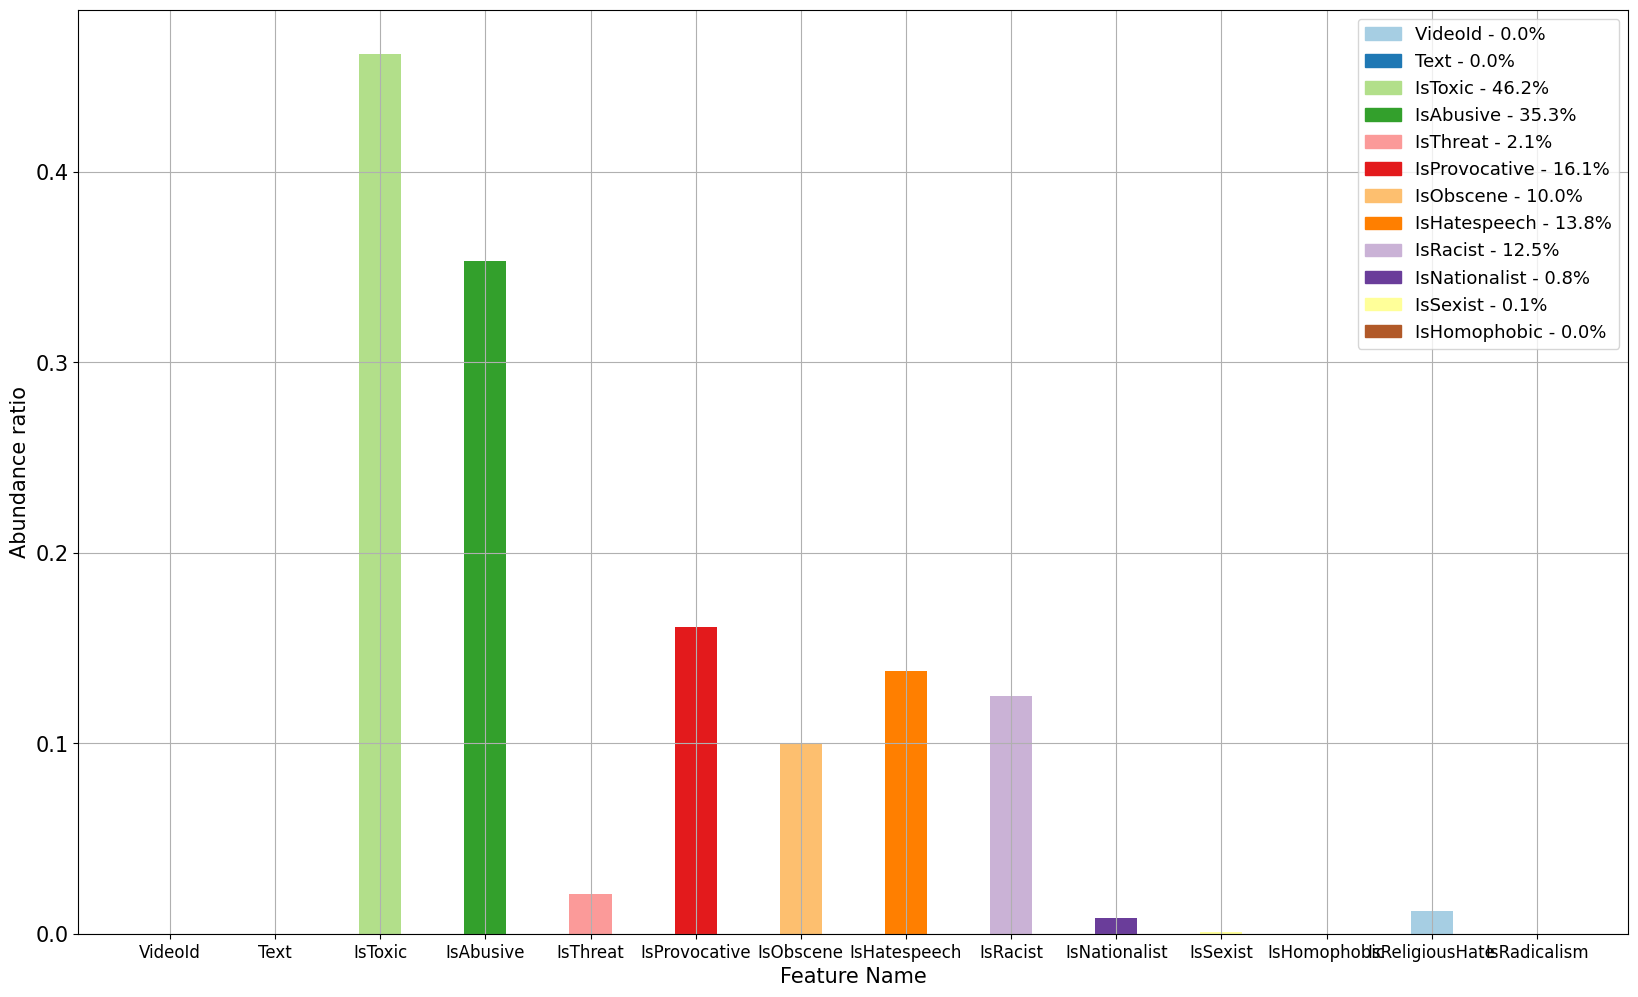

In [85]:
columns_names = df.columns.tolist()
bar_df = {}
for name in columns_names[1:]:
    bar_df[name] = len(df.loc[df[name] == 1]) / len(df[name])
    
    
bar_name = list(bar_df.keys())
values = list(bar_df.values())
fig = plt.figure(figsize = (20, 12))
colors = plt.cm.Paired(np.arange(12))

plt.bar(bar_name, values, color = colors,
        width = 0.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel("Feature Name", fontsize=15)
plt.ylabel("Abundance ratio", fontsize=15)
#plt.title("Percentage of each feature from all comments", fontsize=30)

patch = [mpatches.Patch(color=color, label=f"{bar_name} - {value*100}%") 
         for color,value, bar_name in zip(colors, values, bar_name)]
plt.legend(handles=patch, fontsize=13)
plt.grid()
plt.show()

## Analysis of Boolean Column Distributions

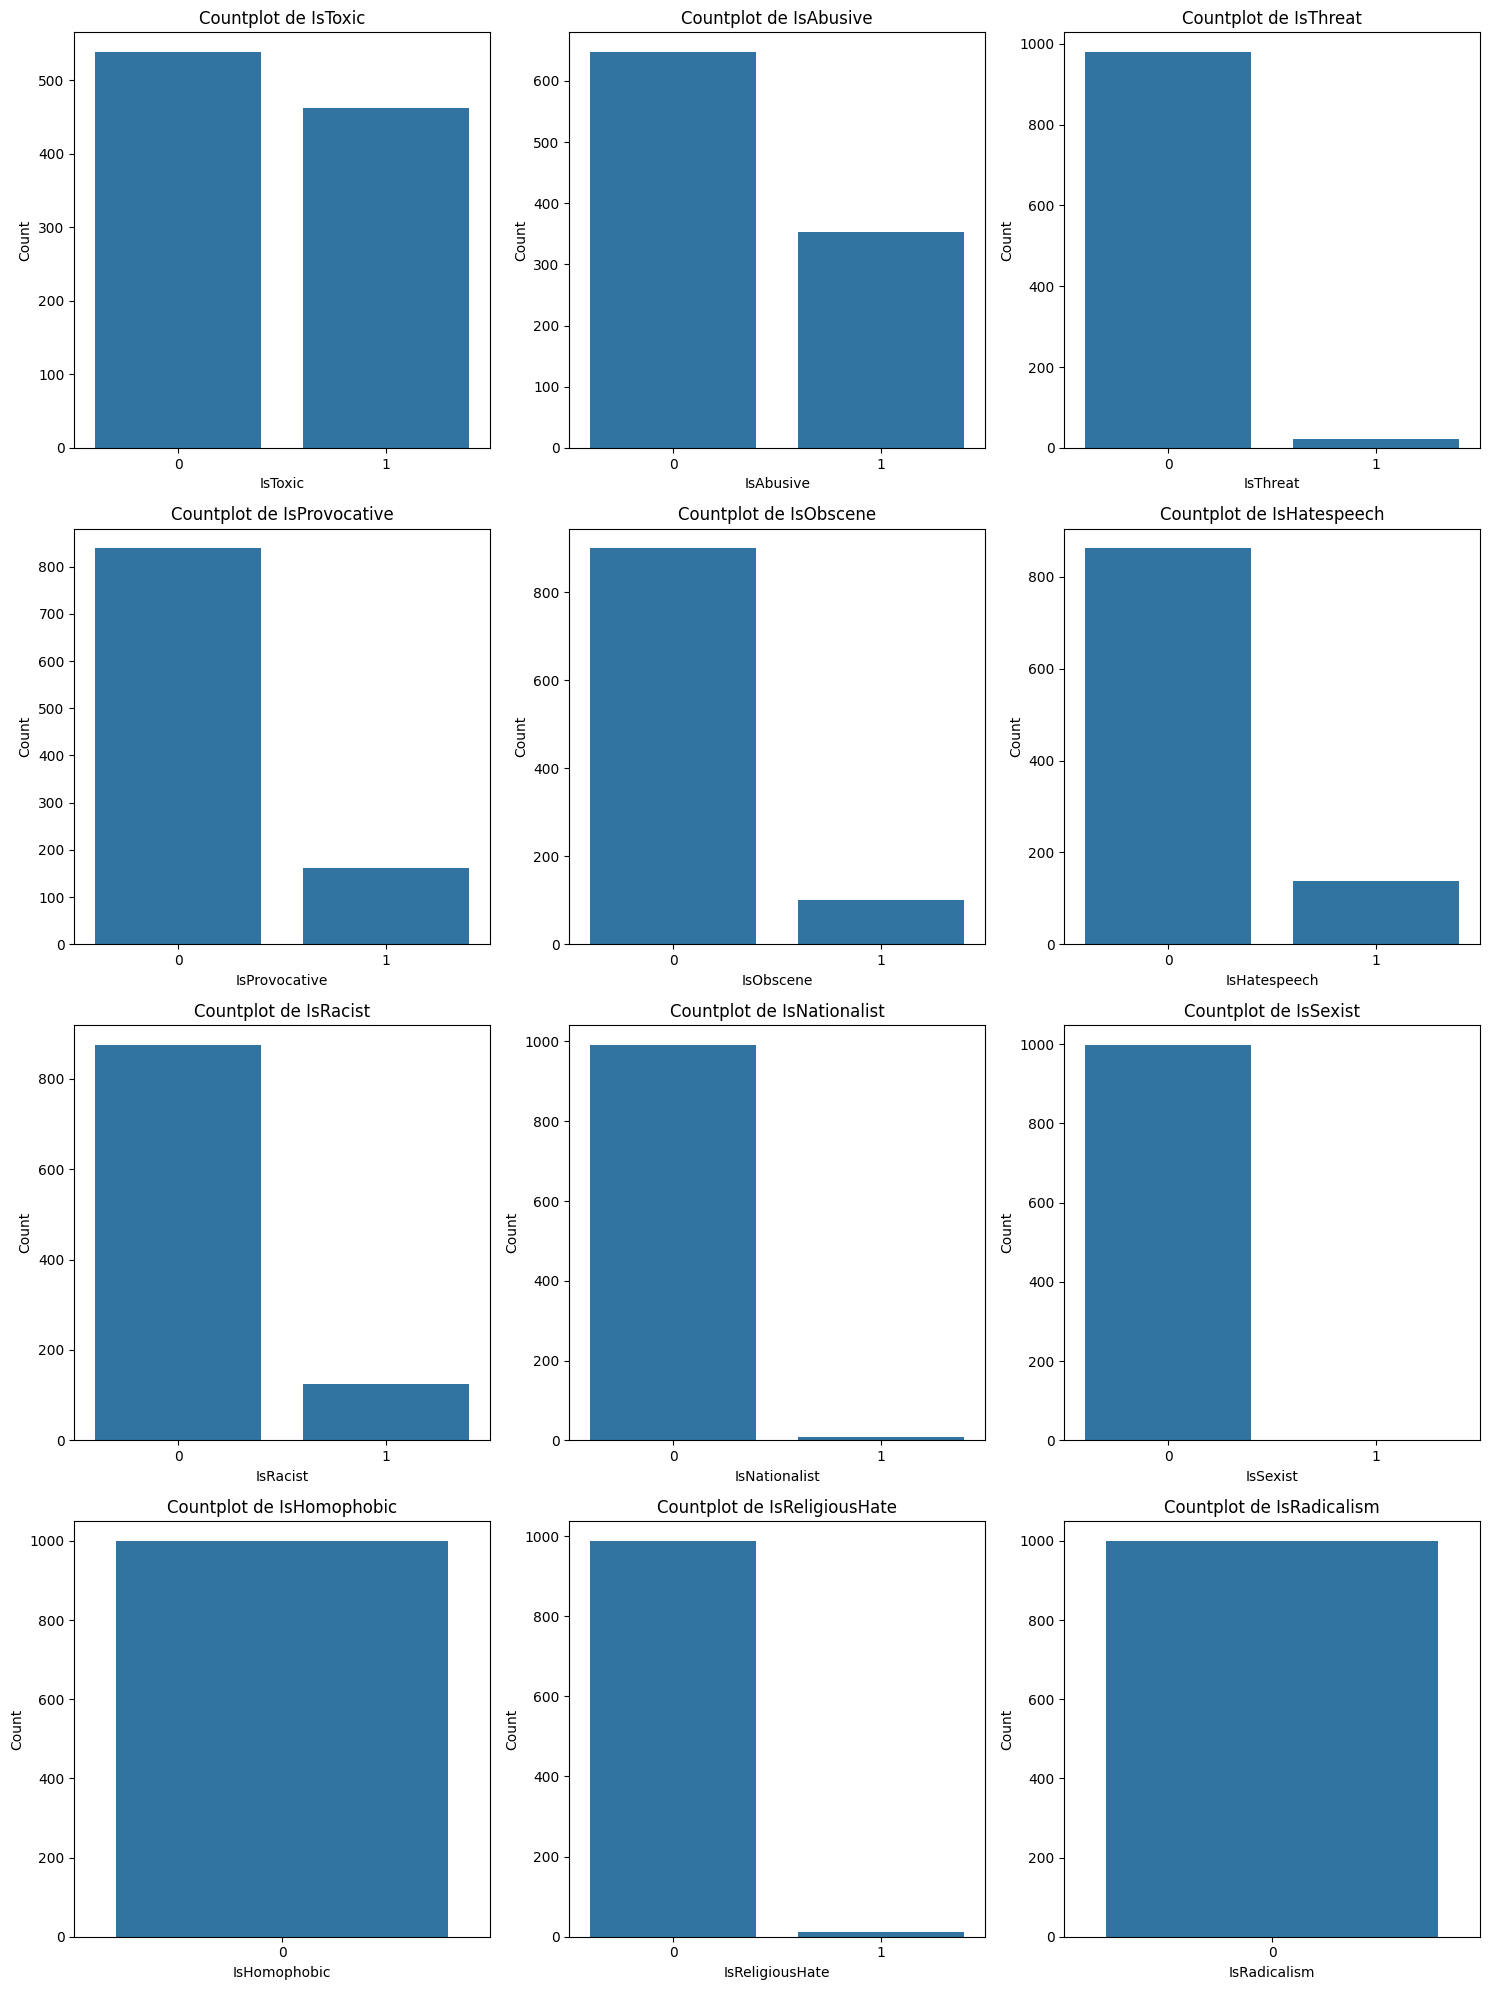

In [86]:
boolean_columns = [column for column in df.columns if df[column].dtype == bool]

num_plots = len(boolean_columns)
num_cols = 3  
num_rows = -(-num_plots // num_cols)  

plt.figure(figsize=(15, 5 * num_rows))

for i, column in enumerate(boolean_columns):
    df[column] = df[column].map({True: 1, False: 0})

    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(data=df, x=column)
    plt.title(f'Countplot de {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Summary of Column Analysis

- Columns like "IsToxic"  and "IsAbusive" display a more balanced distribution between True and False, which could be beneficial for training a model as there is a considerable number of samples for both classes.

- Some columns exhibit a significant imbalance between True and False, for example, "IsHomophobic" and "IsRadicalism". This could potentially bias the model towards the majority class and impact its ability to predict the minority class accurately.

- Columns like "IsThreat", "IsNationalist", "IsSexist" and "IsReligiousHate",  predominantly consist of a single class, which might not be useful for model training due to the lack of sufficient samples for the other class. 

Imbalanced columns may introduce biases into the model. It is essential to consider whether the imbalance accurately represents the class distribution in the data or if it is due to how the data was collected.

## The correlation matrix

In [87]:
# Distribution of tags in each category
toxic_labels = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

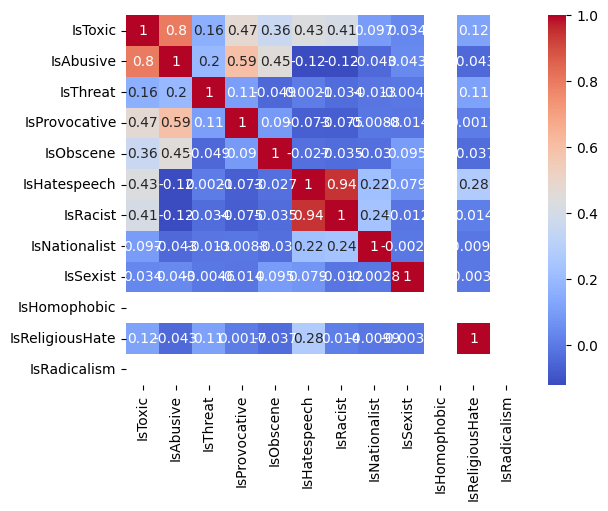

In [88]:
correlation_matrix = df[toxic_labels].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [89]:
corr_matrix = df.corr()
corr_matrix["IsToxic"].sort_values(ascending = False)

ValueError: could not convert string to float: 'Ugg2KwwX0V8-aXgCoAEC'

The correlation analysis suggests that columns like "IsAbusive", "IsProvocative", "IsHatespeech", "IsRacist" and "IsObscene" could be **more influential or related** to the presence of toxicity, while "IsHomophobic" and "IsRadicalism" **seem to have no linear correlation** with "IsToxic".

## Visualization of Toxic and Non-Toxic Text Distribution

In [ ]:
# split all text by toxic parameter
non_toxic_mark = df.IsToxic.loc[df.IsToxic==0]
toxic_mark = df.IsToxic.loc[df.IsToxic==1]

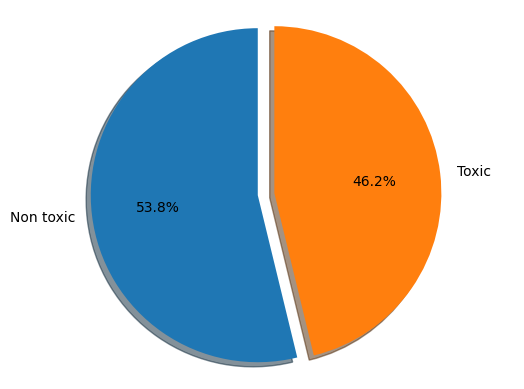

In [ ]:
labels = "Non toxic", "Toxic"
sizes = [non_toxic_mark.count(), 
         toxic_mark.count()]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%",
        shadow=True, startangle=90)
ax1.axis("equal") 
plt.show()

The dataset exhibits a relatively balanced distribution with 53.8% of comments labeled as non-toxic and 46.2% as toxic. This balanced ratio between toxic and non-toxic comments is crucial for modeling, enabling the consideration of both categories effectively in the training process. The proportionate representation of both types of comments suggests the significance of a comprehensive analysis, potentially influencing the model's training and evaluation, ensuring a more robust performance and generalization for the classification task.

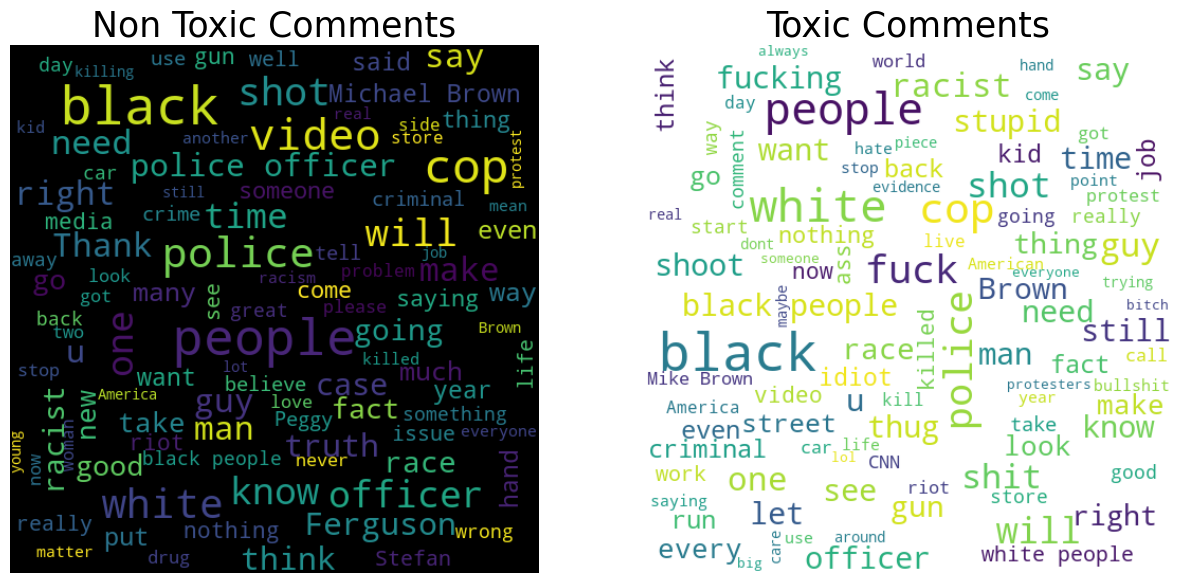

In [ ]:
# Create a chain of more frequent Non-toxic comments in dataframe

untoxic_comments = df.Text.loc[df.IsToxic==0]
new_untoxic_commentss = untoxic_comments.value_counts().to_frame().head(1000)
full_untoxic_commentss = "".join(new_untoxic_commentss.index.tolist())

# Create a chain of more frequent toxic comments in dataframe

toxic_comments = df.Text.loc[df.IsToxic==1]
new_toxic_commentss = toxic_comments.value_counts().to_frame().head(1000)
full_toxic_commentss = "".join(new_toxic_commentss.index.tolist())

# Generate a visual image of the most frequent words in a set of non-toxic and toxic comments

wordcloud_untoxic = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_untoxic_commentss)

wordcloud_toxic = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_toxic_commentss) 

# Data visualization

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_untoxic, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_toxic, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Toxic Comments", fontsize=25)
ax2.set_title("Toxic Comments", fontsize=25)
plt.show()   

## Cleaning and initial text processing

In [ ]:
stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    
    # Convert text to lowercase
    text = str(text).lower()

    # Remove non-alphabetic characters 
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords
    text = text.split()
    text = [word for word in text if word not in stopword]

    # Lemmatize
    text = [lemmatizer.lemmatize(word) for word in text]

    # Tokenize the text
    tokens = [token.lower() for token in word_tokenize(' '.join(text))]   
    
    # Join the tokens into a single string
    text = ' '.join(tokens)

    return text

In [ ]:
# Examples before and after preprocessing

for idx in range(5):  
    original_text = df["Text"].iloc[idx]
    preprocessed_text = preprocess_text(original_text)
    print(f"Original: {original_text}")
    print(f"Preprocesado: {preprocessed_text}\n")

Original: If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation.  To lump yourself into this mess and take matters into your own hands makes these kinds of protests selfish and without rational thought and investigation.  The guy in this video is heavily emotional and hyped up and wants to be heard, and when he gets heard he just presses more and more.  He was never out to have a reasonable discussion.  Kudos to the Smerconish for keeping level the whole time and letting Masri make himself out to be a fool.  How dare he and those that tore that city down in protest make this about themselves and to dishonor the entire incident with their own hate.  By the way, since when did police brutality become an epidemic?  I wish everyone would just stop pretending like they were there and they knew EXACTLY what was going on, because there's no measurable amount of people that honestly witnessed this in

We decided based on the previous study carried out, to temporarily dispense with all the columns except "Text" and "IsToxic" (column to predict), to perform the following tests and check how the model fares with that decision.

## New Dataset

In [ ]:
# Copy Dataframe

data_clean = df.copy()

In [ ]:
# Create new dataset with only 'Text' and 'IsToxic' columns

data_clean = data_clean[["Text", "IsToxic"]]

In [ ]:
# Preprocess the text

data_clean["Text"] = data_clean["Text"].apply(preprocess_text)

### Split data into training and test sets

In [ ]:
X = data_clean['Text']
y = data_clean.drop(['Text'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("X_train:")
print(X_train)
print()

print("y_train:")
print(y_train)
print()

print("X_test:")
print(X_test)
print()

print("y_test:")
print(y_test)

X_train:
29     blood street worried word getting tired way ma...
535    really care much cop somebody tell dumb as gir...
695    dumb fuck screwing fellow citizen instead prot...
557    non lethal weapon control crowd lol love rogan...
836    yea beat white people rob black owned store ca...
                             ...                        
106    think indecent unessacerry event one person sh...
270    clearly racist shrill canadian vegatable plant...
860    people see herei cant even understand sayingis...
435                 far base cant even call propaganda b
102    dont want son death vain let burn bitch stupid...
Name: Text, Length: 800, dtype: object

y_train:
     IsToxic
29     False
535     True
695     True
557     True
836     True
..       ...
106    False
270     True
860     True
435     True
102     True

[800 rows x 1 columns]

X_test:
521    call anarchist defend cop shooting unarmed civ...
737                    mother told thing god bless woman
740    love 

In [ ]:
# Configure the synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet')

# Apply the synonym replacement technique to the training set
X_train_augmented = X_train.apply(lambda x: aug.augment(x))

for i in range(5):
    print("Original:", X_train.iloc[i])
    print("Augmented:", X_train_augmented.iloc[i])
    print("=" * 50)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bniet\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


Original: blood street worried word getting tired way mainstream medium treating u like idiot follow condescending irrelevant distracting disparaging narrative step cnn
Augmented: ['blood street worried word getting tired way mainstream spiritualist deal u like idiot postdate lower oneself irrelevant distracting disparage narrative footmark cnn']
Original: really care much cop somebody tell dumb as girl unarmed white people every year killed black week ago black cop shot unarmed white man salt lake city crime committed black understand crime poverty related ad white woman raped black fbi report fuck rape poor answer nothing anyone rape someone hanged neck dead
Augmented: ['very care much copper soul distinguish dumb as girl unarmed snowy multitude every year killed black week ago black cop shot unarmed white world salt lake city crime committed black understand law breaking poorness related ad white woman raped black fbi report fuck rape poor answer nothing anyone rape somebody hanged 


### Vectorizing the Text column

In [ ]:
# Convert X_train and X_train_augmented to lists of strings
X_train_list = [' '.join(doc) for doc in X_train]
X_train_augmented_list = [' '.join(doc) for doc in X_train_augmented]

# Concatenate the lists
X_train_combined_list = X_train_list + X_train_augmented_list

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform training data (original + augmented) to TF-IDF space
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_combined_list)

# Transform test data to TF-IDF space
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Guardar el vectorizador en un archivo pickle
with open('../modelos/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [ ]:
# Tokenization examples
for idx in range(5):  
    original_text = data_clean["Text"].iloc[idx]
    preprocessed_text = preprocess_text(original_text)
    tokens = word_tokenize(preprocessed_text)
    print(f"Original: {original_text}")
    print(f"Tokens: {tokens}\n")

Original: people would take step back make case wasnt anyone except two people situation lump mess take matter hand make kind protest selfish without rational thought investigation guy video heavily emotional hyped want heard get heard press never reasonable discussion kudos smerconish keeping level whole time letting masri make fool dare tore city protest make dishonor entire incident hate way since police brutality become epidemic wish everyone would stop pretending like knew exactly going there measurable amount people honestly witnessed incident none u clue way whole issue swung grand jury informed trust majority rule right course action let also thank police officer america actually serve protect even youre bit jerk pull respect job know someone many people going pout held accountable action people hate police need officer two around emergency
Tokens: ['people', 'would', 'take', 'step', 'back', 'make', 'case', 'wasnt', 'anyone', 'except', 'two', 'people', 'situation', 'lump', 'mes

In [ ]:
# Print some features of the training TF-IDF matrix
print("Matriz TF-IDF de entrenamiento:")
print()
print(X_train_tfidf[:5, :])  
print()
# Print some features of the test TF-IDF matrix
print("Matriz TF-IDF de prueba:")
print()
print(X_test_tfidf[:5, :])  

Matriz TF-IDF de entrenamiento:



Matriz TF-IDF de prueba:

  (0, 4546)	0.13418534754310463
  (0, 4505)	0.09720524711451865
  (0, 4499)	0.15397346891252653
  (0, 4353)	0.1099707588661524
  (0, 4242)	0.15397346891252653
  (0, 4231)	0.15077714147693888
  (0, 4149)	0.15397346891252653
  (0, 4144)	0.18396072934460736
  (0, 3843)	0.12549851545661148
  (0, 3823)	0.1373816749786923
  (0, 3720)	0.16202757079889016
  (0, 3631)	0.14107156420595307
  (0, 2630)	0.11913840566023587
  (0, 2405)	0.16202757079889016
  (0, 2348)	0.1742551520736216
  (0, 2333)	0.16202757079889016
  (0, 2331)	0.10137872650288643
  (0, 2324)	0.11411834652800676
  (0, 2245)	0.11285821880564886
  (0, 2041)	0.18396072934460736
  (0, 2002)	0.11411834652800676
  (0, 1990)	0.1673689354107731
  (0, 1917)	0.3485103041472432
  (0, 1873)	0.1742551520736216
  (0, 1863)	0.1742551520736216
  :	:
  (2, 846)	0.24485206964598794
  (3, 4523)	0.25767207873671716
  (3, 4111)	0.15254462962367787
  (3, 3823)	0.1924292314898315
  (3, 3718)	0.

Based on the experiments carried out in the "Experiments" notebook with different models, the decision was made to implement the following model for predictions within the API.

### Implementing XGBoost Model

In [90]:
y_train_duplicated = np.concatenate([y_train, y_train])

xgb = XGBClassifier()

xgb.fit(X_train_tfidf, y_train_duplicated)

y_pred_train_xgb = xgb.predict(X_train_tfidf)

y_pred_test_xgb = xgb.predict(X_test_tfidf)

accuracy_train_xgb = accuracy_score(y_train_duplicated, y_pred_train_xgb)
print("Accuracy Train Xgb: {:.2f}%".format(accuracy_train_xgb * 100))

accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
print("Accuracy Test Xgb: {:.2f}%".format(accuracy_test_xgb * 100))

overfitting_xgb = accuracy_train_xgb - accuracy_test_xgb
print("Overfitting Xgb: {:.2f}%".format(overfitting_xgb * 100))

Accuracy Train Xgb: 73.81%
Accuracy Test Xgb: 72.50%
Overfitting Xgb: 1.31%


In [93]:
# Guardar el modelo en un archivo pickle
with open('../modelos/modelo_xgboost.pkl', 'wb') as file:
    pickle.dump(xgb, file)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=846770f1-0f5d-4ae6-9d23-5fd9cb12a1f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>